In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [3]:
train=pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
train_extra=pd.read_csv('/kaggle/input/playground-series-s5e2/training_extra.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')

In [27]:
train.shape, test.shape, train_extra.shape

((3994318, 11), (200000, 10), (3694318, 11))

In [28]:
train = pd.concat([train, train_extra], ignore_index=True)

In [30]:
train.shape

(7688636, 11)

In [31]:
train.sample(5)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
4697568,1203250,NaN,Nylon,Large,8.0,No,No,Backpack,Pink,13.274916,80.17618
7043136,3548818,Nike,Leather,Small,8.0,Yes,No,Backpack,NaN,23.450037,42.30504
588170,788170,Jansport,Nylon,Large,6.0,Yes,No,Messenger,Blue,10.873644,146.43739
4715040,1220722,Nike,Nylon,Medium,9.0,Yes,Yes,Messenger,Pink,9.793847,139.32189
3256546,3456546,Under Armour,Nylon,Small,2.0,No,No,Tote,Green,27.859028,29.63662


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7688636 entries, 0 to 7688635
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 645.3+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 193773 non-null  object 
 2   Material              194387 non-null  object 
 3   Size                  195619 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    195038 non-null  object 
 6   Waterproof            195189 non-null  object 
 7   Style                 194847 non-null  object 
 8   Color                 193215 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(train.drop(columns='Price'),train['Price'],test_size=0.2)

In [11]:
cat_cols=train.select_dtypes(include='object').columns.tolist()

<Axes: xlabel='Price', ylabel='Density'>

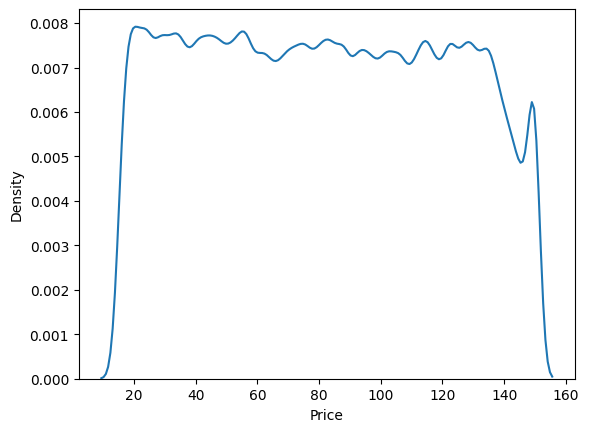

In [12]:
sns.kdeplot(x=train['Price'])

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


**DATA PREPROCESSING**

In [14]:
weight_capacity_pipe=Pipeline(steps=[('scaler',StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('weight_capacity_pipe', weight_capacity_pipe, ['Weight Capacity (kg)']),
        ('cat_pipeline', Pipeline(steps=[
            ('encoder', OneHotEncoder())
        ]), cat_cols)
    ],
    remainder='passthrough'
)
# no manual imputation as LightGBM inherently handles missing values

**MODEL BUILDING**

In [15]:
# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor())
])

# Perform cross-validation
rmse_scorer = make_scorer(mean_squared_error, squared=False)
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)

print(f'Cross-Validation RMSE: {np.mean(scores):.4f}')

# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Test set predictions
y_pred = pipeline.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test Set RMSE: {test_rmse:.4f}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 2556363, number of used features: 35
[LightGBM] [Info] Start training from score 81.353474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 2556363, number of used features: 35
[LightGBM] [Info] Start training from score 81.392420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [34]:
# Make predictions on the test set
predictions = pipeline.predict(test)

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],         # Ensure 'id' exists in the test set
    'Price': predictions      # Use predictions on the test set
})

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)
